# Augmented Reality 

## Feature Detection

### Feature Detection on Pattern Image

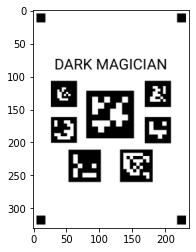

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read pattern
pattern = cv2.imread('demo/pattern_dm.png')
plt.imshow(pattern)
plt.show()

In [2]:
# create feature detection
orb = cv2.ORB_create()

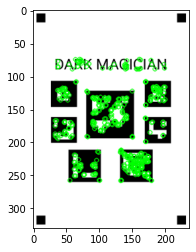

In [3]:
# Compute model keypoints and its descriptors
kp_pattern, des_pattern = orb.detectAndCompute(pattern, None)

# draw keypoint
pattern_kp = cv2.drawKeypoints(pattern, kp_pattern, None, color=(0, 255, 0), flags=0)

plt.imshow(pattern_kp)
plt.show()

### Feature Detection on Frame Image

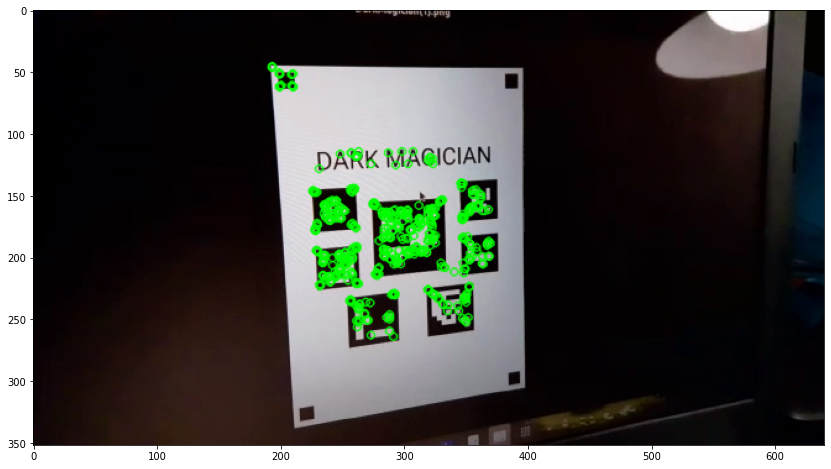

In [9]:
# load video
cap = cv2.VideoCapture('demo/video_dm.mp4')

i = 0
while True:
    ret, frame = cap.read()
    if not ret:
        print('Video Finished')
        break
    
    # detect keypoint and descripton from video frame
    kp_frame, des_frame = orb.detectAndCompute(frame, None)

    i = i + 1

    # just get frame index 10
    if i == 10:
        break

# draw keypoint
frame_kp = cv2.drawKeypoints(frame, kp_frame, None, color=(0, 255, 0), flags=0)

plt.figure(figsize=(18,8))
plt.imshow(frame_kp)
plt.show()

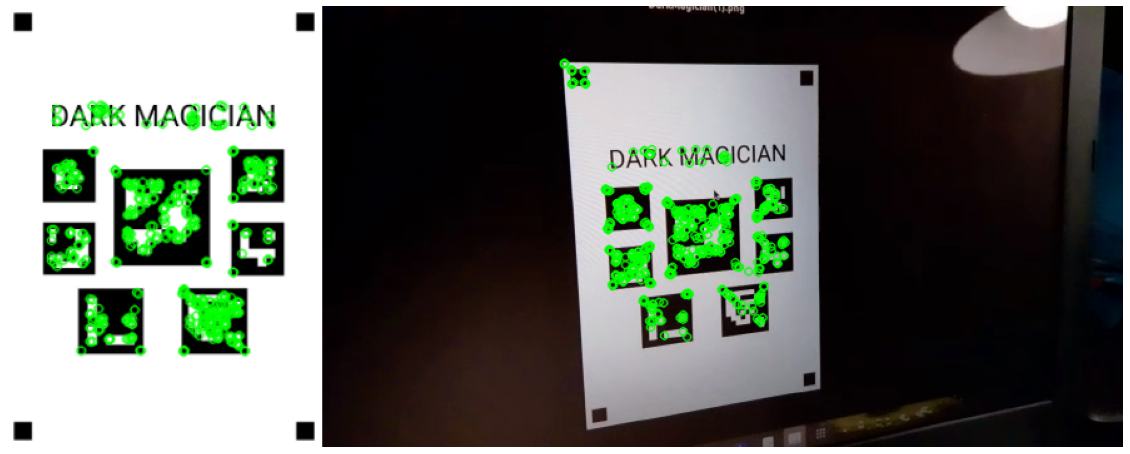

In [16]:
# combine
# resize
dst_h = frame_kp.shape[0]
scale_h = dst_h / pattern_kp.shape[0]

frame_1 = cv2.resize(pattern_kp, (int(pattern_kp.shape[1]*scale_h), int(pattern_kp.shape[0]*scale_h)), interpolation=cv2.INTER_LINEAR)

comb_1 = np.hstack((frame_1, frame_kp))

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(comb_1)

## Feature Matching

In [18]:
# create BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# calculate matches
matches = bf.match(des_pattern, des_frame)
matches = sorted(matches, key=lambda x: x.distance)

print(f'Matches: {len(matches)}')

Matches: 209


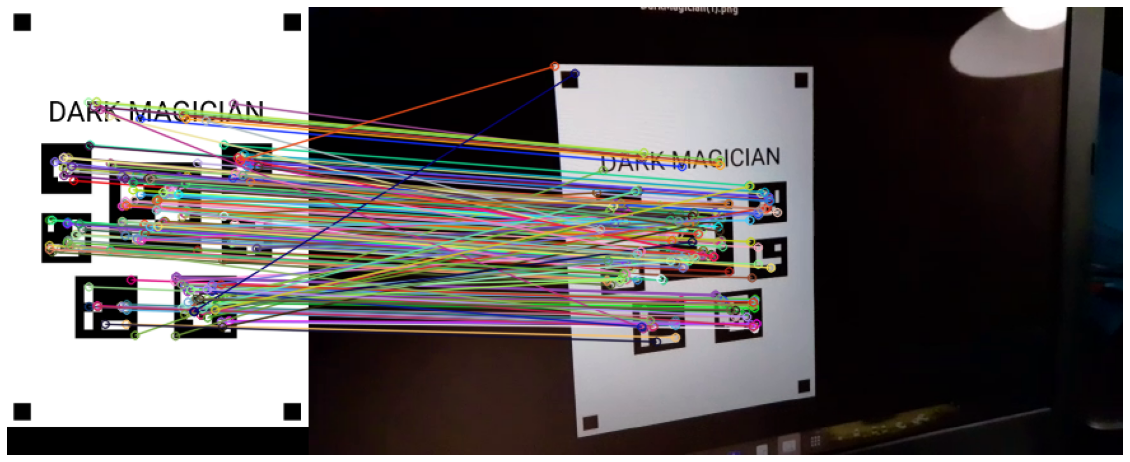

In [19]:
# draw matches
matches_draw = cv2.drawMatches(pattern, kp_pattern, frame, kp_frame, matches, 0, flags=2)

plt.figure(figsize=(20, 10))
plt.imshow(matches_draw)
plt.axis('off')
plt.show()

## Compute Homography

In [21]:
# get src point and dst point from matches
src_pts = np.float32([kp_pattern[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

In [22]:
# compute homography
homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
print('Perspective Transformation Matrix:\n', homography, homography.shape)

Perspective Transformation Matrix:
 [[1.09788968e+00 1.08535635e-01 1.94274922e+02]
 [4.31463521e-02 9.60981834e-01 4.70337243e+01]
 [6.32588276e-04 2.45446053e-04 1.00000000e+00]] (3, 3)


In [23]:
# get four point transformation
h, w, c = pattern.shape
pts_pattern = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
print('Pattern Points:\n', np.squeeze(pts_pattern))

# compute pts augmented
pts_augmented = cv2.perspectiveTransform(pts_pattern, homography)
print('Augmented Points:\n', np.squeeze(pts_augmented))

Pattern Points:
 [[  0.   0.]
 [  0. 329.]
 [236. 329.]
 [236.   0.]]
Augmented Points:
 [[194.27492   47.033726]
 [212.79924  336.05936 ]
 [397.6164   303.5499  ]
 [394.48404   49.783974]]


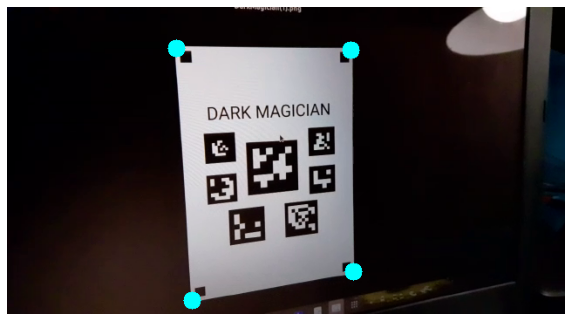

In [26]:
# draw transformation keypoint
for draw_point in pts_augmented:
    circle_frame = cv2.circle(frame, tuple(np.squeeze(draw_point)), radius=10, color=(0, 255, 255), thickness=-1)

plt.figure(figsize=(10, 8))

plt.imshow(circle_frame)
plt.axis('off')
plt.show()

In [27]:
# draw augmneted image
overlay_image = cv2.imread('./demo/overlay_dm.jpg')
pts_overlay = np.float32([[0, 0], 
                    [0, overlay_image.shape[0]],
                    [overlay_image.shape[1], overlay_image.shape[0]],
                    [overlay_image.shape[1], 0]])
print('Overlay Points:\n', pts_overlay)

Overlay Points:
 [[  0.   0.]
 [  0. 614.]
 [421. 614.]
 [421.   0.]]


In [28]:
# compute transformation matrix
M = cv2.getPerspectiveTransform(pts_overlay, pts_augmented)
print('Tranformation Matrix:\n', M)

Tranformation Matrix:
 [[6.15444046e-01 5.81567853e-02 1.94274918e+02]
 [2.41865441e-02 5.14923554e-01 4.70337257e+01]
 [3.54609877e-04 1.31517757e-04 1.00000000e+00]]


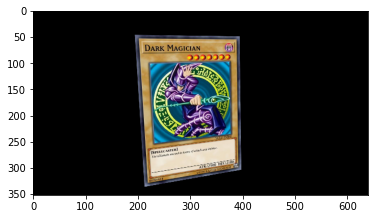

In [29]:
# warping overlay image to frame
warp = cv2.warpPerspective(overlay_image, M, (frame.shape[1], frame.shape[0]))
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2RGB)

plt.imshow(warp)
plt.show()

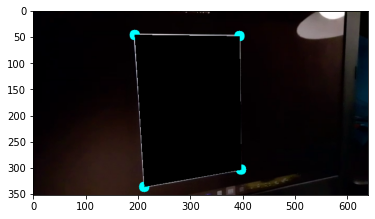

In [30]:
# create mask image and combine them
dst_image_gray = cv2.cvtColor(warp, cv2.COLOR_RGB2GRAY)
ret, mask = cv2.threshold(dst_image_gray, 0, 255, cv2.THRESH_BINARY_INV)

# Compute bitwise conjunction using the calculated mask:
image_masked = cv2.bitwise_and(frame, frame, mask=mask)

plt.imshow(image_masked)
plt.show()

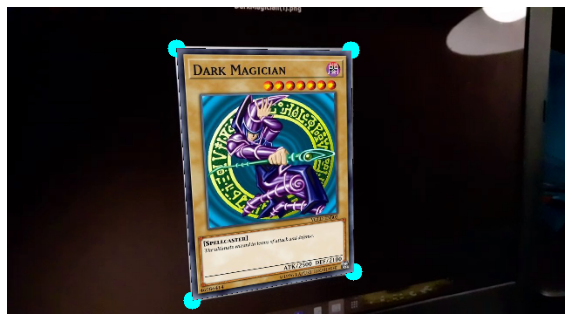

In [32]:
# add warp image
result = cv2.add(warp, image_masked)

plt.figure(figsize=(10, 8))
plt.imshow(result)
plt.axis('off')
plt.show()